In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection, linear_model, decomposition
import numpy as np
import scipy

import tensorflow as tf

%matplotlib inline

In [2]:
df_train = pd.read_csv("/data/MNIST/mnist_train.csv", header= None)
df_test = pd.read_csv("/data/MNIST/mnist_test.csv", header= None)
print("Train shape", df_train.shape, "Test shape", df_test.shape)

Train shape (60000, 785) Test shape (10000, 785)


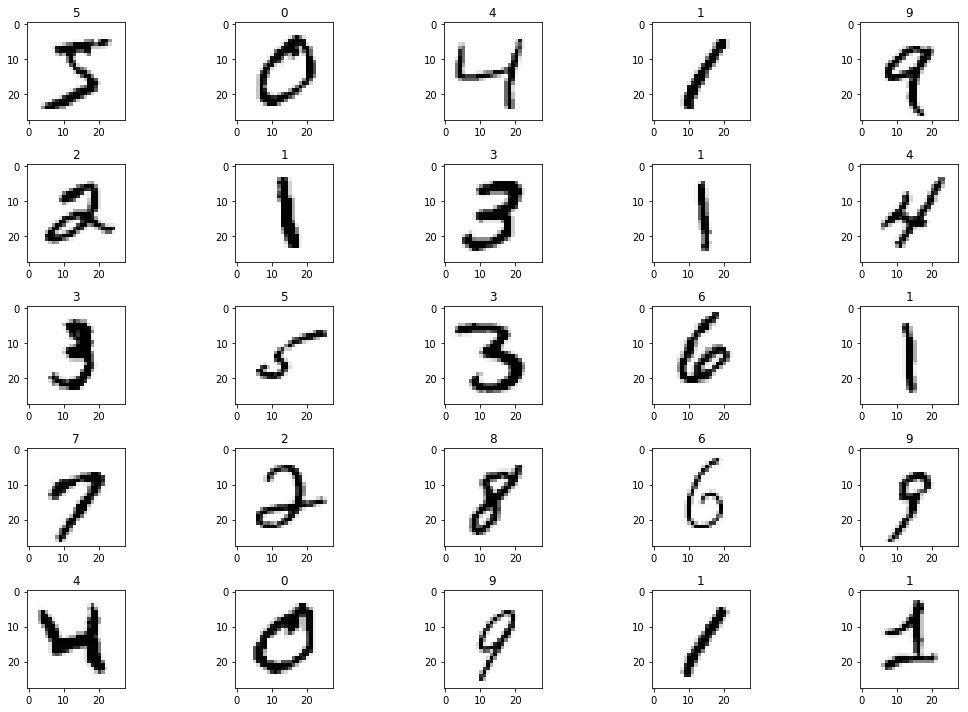

In [3]:
fig, _ = plt.subplots(5, 5, figsize = (15, 10))
for i, ax in enumerate(fig.axes):
    ax.imshow(df_train.iloc[i, 1:].values.reshape(28, -1), cmap="Greys")
    ax.set_title(df_train.iloc[i, 0])

plt.tight_layout()

In [4]:
X_train = df_train.iloc[:, 1:].values.astype(np.float32)
X_test = df_test.iloc[:, 1:].values.astype(np.float32)
y_train = df_train.iloc[:, 0]
y_test = df_test.iloc[:, 0]

Text(0.5,0,'Class')

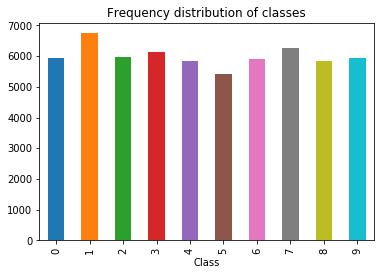

In [5]:
pd.Series(y_train).value_counts().sort_index().plot.bar()
plt.title("Frequency distribution of classes")
plt.xlabel("Class")

Text(0.5,0,'Class')

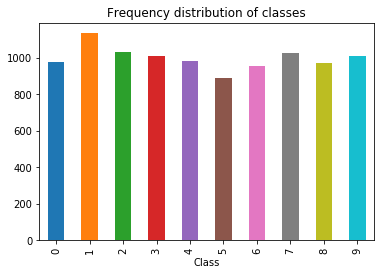

In [6]:
pd.Series(y_test).value_counts().sort_index().plot.bar()
plt.title("Frequency distribution of classes")
plt.xlabel("Class")

### Data density 

In [7]:
np.sum(X_train.flatten() > 0) / len(X_train.flatten())

0.19120229591836735

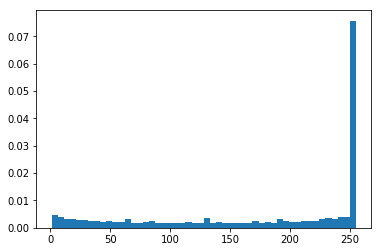

In [8]:
s = X_train.flatten()
s = s[s > 0]
plt.hist(s, bins = 50, normed = True);

In [9]:
scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [10]:
%%time
est = linear_model.LogisticRegression(C = 1.0, random_state = 1, multi_class="multinomial",
                                      solver="lbfgs", max_iter=10000)
est.fit(X_train_std, y_train)
print("accuracy", est.score(X_test_std, y_test), "iterations:", est.n_iter_)

accuracy 0.9211 iterations: [899]
CPU times: user 9min 10s, sys: 26.9 s, total: 9min 36s
Wall time: 2min 51s


In [11]:
est.coef_.shape

(10, 784)

In [12]:
%%time
np.random.seed(1)
inits = np.random.randn(10, 784) 
inits = inits / np.std(inits, axis=1).reshape(10, -1)
#inits = np.zeros([10, 784])

est = linear_model.SGDClassifier(n_jobs=4, tol=1e-5, eta0 = 0.15, random_state=1,  
                                 learning_rate = "invscaling", 
                                 alpha = 0.01, max_iter= 100)
est.fit(X_train_std, y_train, inits)
print("accuracy", est.score(X_test_std, y_test), "iterations:", est.n_iter_)

accuracy 0.9216 iterations: 59
CPU times: user 31.6 s, sys: 253 ms, total: 31.9 s
Wall time: 10.1 s


In [13]:
est.coef_.shape

(10, 784)

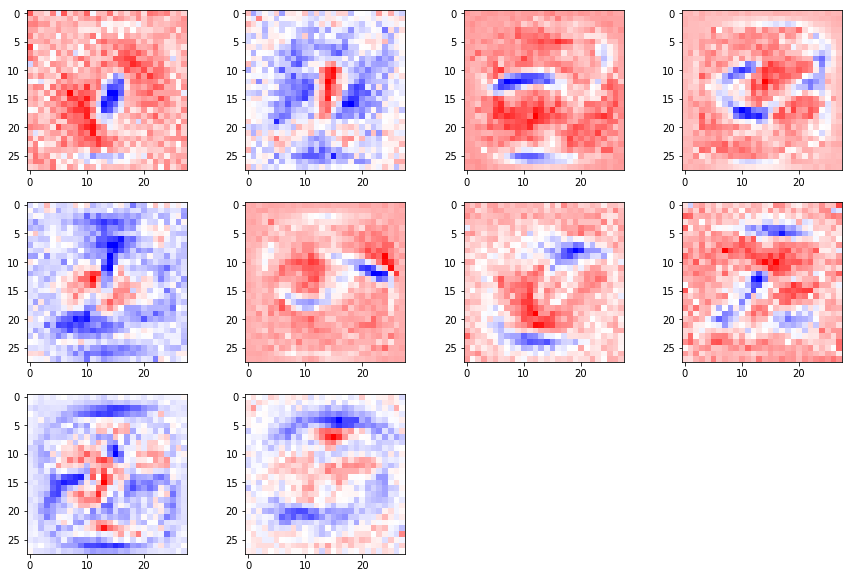

In [14]:
fig, _ = plt.subplots(3, 4, figsize = (15, 10))
for i, ax in enumerate(fig.axes):
    if i < est.coef_.shape[0]:
        ax.imshow(est.coef_[i, :].reshape(28, 28), cmap = "bwr", interpolation="nearest")
    else:
        ax.remove()

# Impact of dimensionality reduction

In [18]:
%%time
est = linear_model.SGDClassifier(n_jobs=4, tol=1e-5, eta0 = 0.15, random_state=1,  
                                 learning_rate = "invscaling", 
                                 alpha = 0.01, max_iter= 100)
est.fit(X_train_std, y_train, inits)
print("accuracy", est.score(X_test_std, y_test), "iterations:", est.n_iter_)

accuracy 0.9188 iterations: 17
CPU times: user 13.2 s, sys: 271 ms, total: 13.5 s
Wall time: 5.4 s


In [19]:
pca = decomposition.PCA(random_state=1)
pca.fit(X_train_std)                  

PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0,0.5,'Explained variance ratio')

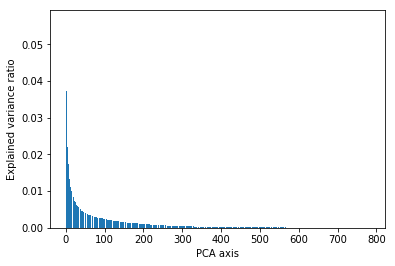

In [20]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("PCA axis")
plt.ylabel("Explained variance ratio")

Text(0,0.5,'Cumulative explained variance')

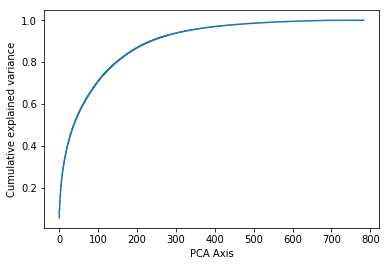

In [21]:
plt.step(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("PCA Axis")
plt.ylabel("Cumulative explained variance")

In [22]:
v = pd.DataFrame({"pca": np.cumsum(pca.explained_variance_ratio_)}).query("pca > 0.99")
v.head()

,pca
542,0.990089
543,0.990183
544,0.990277
545,0.990370
546,0.990462


In [23]:
n_pca = v.index[0]
n_pca, (1 - n_pca/X_train_std.shape[1])

(542, 0.30867346938775508)

In [24]:
%%time
pca = decomposition.PCA(random_state=1, n_components=n_pca)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
print("X_train shape", X_train_pca.shape)

X_train shape (60000, 542)
CPU times: user 24.7 s, sys: 973 ms, total: 25.7 s
Wall time: 11.2 s


In [25]:
%%time
est = linear_model.SGDClassifier(n_jobs=4, tol=1e-5, eta0 = 0.15, random_state=1,  
                                 learning_rate = "invscaling", 
                                 alpha = 0.01, max_iter= 100)
est.fit(X_train_pca, y_train)
print("accuracy", est.score(X_test_pca, y_test), "iterations:", est.n_iter_)

accuracy 0.9189 iterations: 15
CPU times: user 9.08 s, sys: 233 ms, total: 9.31 s
Wall time: 3.11 s


By reducing the dimension by 30% we reduce the training time without a significant drop in accuracy.

# Batch gradient descent using Tensorflow

In [26]:
%%time

tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], len(np.unique(y_train)) 
max_iter = 100
alpha = 100


X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)


W = tf.Variable(tf.truncated_normal([n_x, n_y], stddev=0.1, 
                                    seed = 1, dtype=tf.float32), name = "W")
b = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b")

tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, W)

Z = tf.matmul(X, W) + b
print("Z: ", Z)

y_pred = tf.cast(tf.argmax(Z, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z))

optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    for i in range(max_iter):
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_train_std, y: y_train})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    plot_scores(scores)

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 10), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.52437
10 0.504713
20 0.407154
30 0.353561
40 0.317242
50 0.292892
60 0.277241
70 0.266509
80 0.258999
90 0.253509
Test accuracy:  0.9227


NameError: name 'plot_scores' is not defined

# Mini batch gradient descent

In [27]:
import requests
url = "https://raw.githubusercontent.com/abulbasar/machine-learning/master/Utils.py"
exec(requests.get(url).text)

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 10), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.63887
100 0.484621
200 1.73197
300 0.762925
400 0.244644
500 0.529764
600 0.286891
700 0.160542
800 0.439102
900 0.770548
Test accuracy:  0.9174
CPU times: user 2.17 s, sys: 234 ms, total: 2.4 s
Wall time: 1.83 s


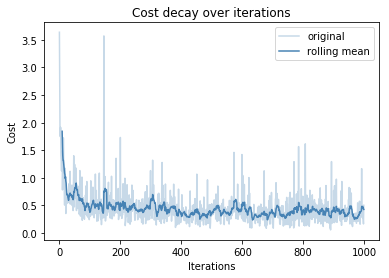

In [28]:
%%time 

tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], 10 # number of features of df is 4, and output is single value 
max_iter = 1000
alpha = 100


X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)

W = tf.Variable(tf.truncated_normal([n_x, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W")
b = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b")

Z = tf.matmul(X, W) + b
print("Z: ", Z)

y_pred = tf.cast(tf.argmax(Z, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    
    batchable = Batchable(X_train_std, y_train, batch_size=64, seed=1)
    
    for i in range(max_iter):
        X_batch, y_batch = batchable.next()
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    plot_scores(scores)
    
    

# No hidden layer 

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 10), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.63887
100 0.484621
200 1.73197
300 0.762925
400 0.244644
500 0.529764
600 0.286891
700 0.160542
800 0.439102
900 0.770548
Test accuracy:  0.9174


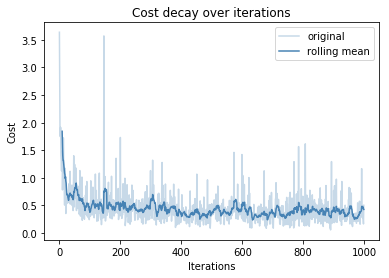

In [29]:
tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], 10 # number of features of df is 4, and output is single value 
max_iter = 1000
alpha = 100


X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)

W1 = tf.Variable(tf.truncated_normal([n_x, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W")
b1 = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b")

Z1 = tf.matmul(X, W1) + b1
print("Z: ", Z1)

y_pred = tf.cast(tf.argmax(Z1, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    
    batchable = Batchable(X_train_std, y_train, batch_size=64, seed=1)
    
    for i in range(max_iter):
        X_batch, y_batch = batchable.next()
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    plot_scores(scores)
    
    

# Regularize model with two hidden layers

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 400), dtype=float32)
A1: Tensor("Tanh:0", shape=(?, 400), dtype=float32)
Z2:  Tensor("add_1:0", shape=(?, 10), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.2614
200 0.524644
400 0.378422
600 0.348137
800 0.381931
1000 0.392987
1200 0.315553
1400 0.461374
1600 0.396431
1800 0.28808
Test accuracy:  0.9227
CPU times: user 32.5 s, sys: 3.06 s, total: 35.6 s
Wall time: 13.3 s


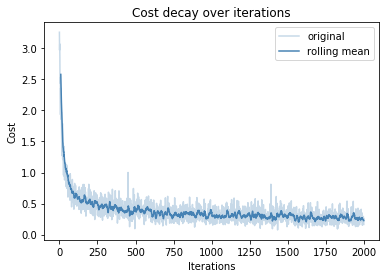

In [30]:
%%time
tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], len(np.unique(y_train)) 
max_iter = 2000
batch_size = 64
alpha = 0.01
n_h = 400
learning_rate = 0.02

X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)

W1 = tf.Variable(tf.truncated_normal([n_x, n_h], stddev=0.1, seed = 1, dtype=tf.float32), name = "W1")
b1 = tf.Variable(tf.zeros(shape=[n_h]), dtype=tf.float32, name="b1")

Z1 = tf.matmul(X, W1) + b1
print("Z: ", Z1)

A1 = tf.nn.tanh(Z1)
print("A1:", A1)

W2 = tf.Variable(tf.truncated_normal([n_h, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W2")
b2 = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b2")

Z2 = tf.matmul(A1, W2) + b2
print("Z2: ", Z2)


y_pred = tf.cast(tf.argmax(Z2, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, W1)
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, W2)

regularizer = tf.contrib.layers.l2_regularizer(scale=alpha)
reg_penalty = tf.contrib.layers.apply_regularization(regularizer, 
                        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z2))
cost_reg = cost + reg_penalty
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_reg)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    
    batchable = Batchable(X_train_std, y_train, batch_size=batch_size, seed=1)
    
    for i in range(max_iter):
        X_batch, y_batch = batchable.next()
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_, y_test_pred = sess.run([accuracy, y_pred], feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    plot_scores(scores)
    
    

# Convolutional neural network using Tensorflow 

X:  Tensor("Placeholder:0", shape=(?, 784), dtype=float32)
y:  Tensor("Placeholder_1:0", shape=(?,), dtype=int32)
y_oh:  Tensor("one_hot:0", shape=(?, 10), dtype=float32)
X_img Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)
conv1 Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
conv2 Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
flat Tensor("Relu_2:0", shape=(?, 3136), dtype=float32)
y_pred Tensor("ArgMax:0", shape=(?,), dtype=int32)
0 training cost:  14.9162 training accuracy:  0.09375
50 training cost:  0.450001 training accuracy:  0.875
100 training cost:  1.9665 training accuracy:  0.898438
150 training cost:  0.196648 training accuracy:  0.9375
200 training cost:  0.17403 training accuracy:  0.953125
250 training cost:  0.0630012 training accuracy:  0.984375
300 training cost:  0.0908474 training accuracy:  0.960938
350 training cost:  0.0878595 training accuracy:  0.96875
400 training cost:  0.0893445 training accuracy:  0.976562
450 training cost: 

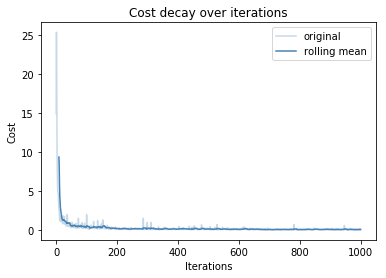

In [31]:
%%time

tf.reset_default_graph()
tf.set_random_seed(1)

n_x = 784
n_y = 10
n_h = 1024

learning_rate = 1e-3
max_iters = 1000

X = tf.placeholder(dtype=tf.float32, shape=[None, n_x])
y = tf.placeholder(dtype=tf.int32, shape=[None])
keep_prob = tf.placeholder(dtype=tf.float32)

print("X: ", X)
print("y: ", y)

y_oh = tf.one_hot(indices=y, depth=n_y)
print("y_oh: ", y_oh)

X_img = tf.reshape(X, shape=[-1, 28, 28, 1])
print("X_img", X_img)


def conv_layer(input, shape):
    """
    The initial 5×5×1 represents the size of the small “window” in the image to be convolved, 
    in our case a 5×5 region. The final 32 is the number of feature maps. In other words, 
    we have multiple sets of weights for the convolutional layer—in this case, 32 of them. 

    The value [1, 1, 1, 1] for strides means that the filter is applied to the input in one-pixel 
    intervals in each dimension, corresponding to a “full” convolution. 
    Setting padding to 'SAME' means that the borders of x are padded such that the size 
    of the result of the operation is the same as the size of x.
    
    Pooling means reducing the size of the data with some local aggregation function. One reason 
    for applying pooling is that we would like our computed features not to care about small changes 
    in position in an image. 
    
    Max pooling outputs the maximum of the input in each region of a predefined size 
    (here 2×2). The ksize argument controls the size of the pooling (2×2), 
    and the strides argument controls by how much we “slide” the pooling grids across x,
    just as in the case of the convolution layer. Setting this to a 2×2 grid means 
    that the output of the pooling will be exactly one-half of the height and width 
    of the original, and in total one-quarter of the size.

    
    """
    W = tf.Variable(tf.truncated_normal(shape=shape, stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[shape[3]]))
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding="SAME")
    A = tf.nn.relu(conv + b)
    return tf.nn.max_pool(A, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')



def full_layer(input, size, activation = True, keep_prob = None):
    input_size = int(input.get_shape()[1])
    W = tf.Variable(tf.truncated_normal(shape=[input_size, size], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[size]))
    Z = tf.matmul(input, W) + b
    if activation:
        Z = tf.nn.relu(Z)
    if not keep_prob is None:
        Z = tf.nn.dropout(Z, keep_prob=keep_prob)
    return Z    
                    
    
conv1 = conv_layer(X_img, [5, 5, 1, 32])
print("conv1", conv1)
conv2 = conv_layer(conv1, [5, 5, 32, 64])
print("conv2", conv2)
conv2_shape = conv2.get_shape() 
flat = tf.nn.relu(tf.reshape(conv2, [-1, conv2_shape[1] * conv2_shape[2] * conv2_shape[3]]))
print("flat", flat)

full_layer_1 = full_layer(flat, n_h, activation = True, keep_prob = keep_prob)
Z = full_layer(full_layer_1, n_y, activation = False)

y_pred = tf.argmax(tf.nn.softmax(Z), axis=1, output_type=tf.int32) 
print("y_pred", y_pred)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=Z))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


with tf.Session() as sess:
    scores = {}
    sess.run(tf.global_variables_initializer())
        
    batchable = Batchable(X_train_std, y_train, batch_size=128)

    for i in range(max_iters):
        X_batch, y_batch = batchable.next()
        accuracy_, cost_, _ = sess.run([accuracy, cost, optimizer]
                        , feed_dict={X: X_batch, y: y_batch, keep_prob: 0.8})
        scores[i] = cost_
        if i % (max_iters // 20) == 0 or i == (max_iters - 1): 
            print(i, "training cost: ", cost_, "training accuracy: ", accuracy_)
            
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test, keep_prob: 1.0})
    print("Test accuracy: ", accuracy_)
    plot_scores(scores)